## Dataset Visualization

### Step 1: Cleaned dataset visualization.

2025-04-28 16:33:17,297 [INFO] Loading processed dataset from D:\Project\Data Science Capstone 2025\src\data\processed\data_cleaning.parquet


Loaded 3726 entries from dataset. Printing head and information about dataset shape.
   label  rating        title  \
0      5       5  Great read!   
3      5       5        Egypt   

                                                text symbols  
0  Great read! I loved it. It is so different fro...          
3  Egypt. A very good book Atmospheric, reflects ...          
<class 'pandas.core.frame.DataFrame'>
Index: 3726 entries, 0 to 4284
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    3726 non-null   int64 
 1   rating   3726 non-null   int64 
 2   title    3726 non-null   object
 3   text     3726 non-null   object
 4   symbols  3726 non-null   string
dtypes: int64(2), object(2), string(1)
memory usage: 174.7+ KB
Using sweetviz to generate a visual report on data...


                                             |          | [  0%]   00:00 -> (? left)

D:\Apps\miniconda3\envs\Data-Science-Capstone-2025\lib\site-packages\sweetviz\graph.py:33: UserWarning: Glyph 128521 (\N{WINKING FACE}) missing from font(s) Roboto.
  figure.savefig(as_raw_bytes, format='png', transparent=True)
D:\Apps\miniconda3\envs\Data-Science-Capstone-2025\lib\site-packages\sweetviz\graph.py:33: UserWarning: Glyph 128580 (\N{FACE WITH ROLLING EYES}) missing from font(s) Roboto.
  figure.savefig(as_raw_bytes, format='png', transparent=True)
D:\Apps\miniconda3\envs\Data-Science-Capstone-2025\lib\site-packages\sweetviz\graph.py:33: UserWarning: Glyph 128153 (\N{BLUE HEART}) missing from font(s) Roboto.
  figure.savefig(as_raw_bytes, format='png', transparent=True)
D:\Apps\miniconda3\envs\Data-Science-Capstone-2025\lib\site-packages\sweetviz\graph.py:33: UserWarning: Glyph 128154 (\N{GREEN HEART}) missing from font(s) Roboto.
  figure.savefig(as_raw_bytes, format='png', transparent=True)
D:\Apps\miniconda3\envs\Data-Science-Capstone-2025\lib\site-packages\sweetviz\gra


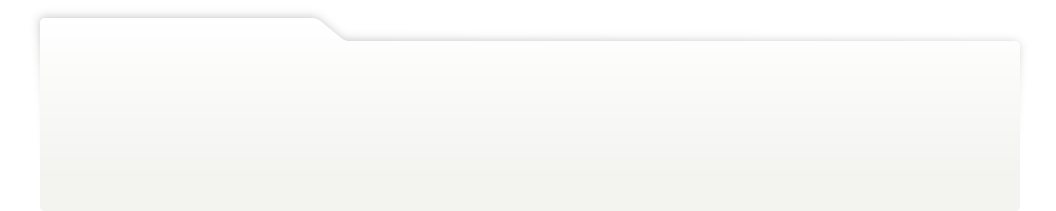
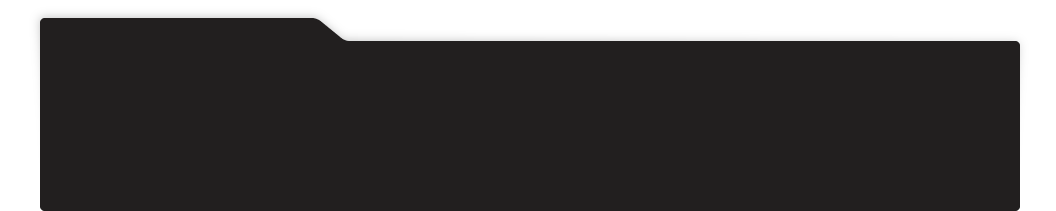
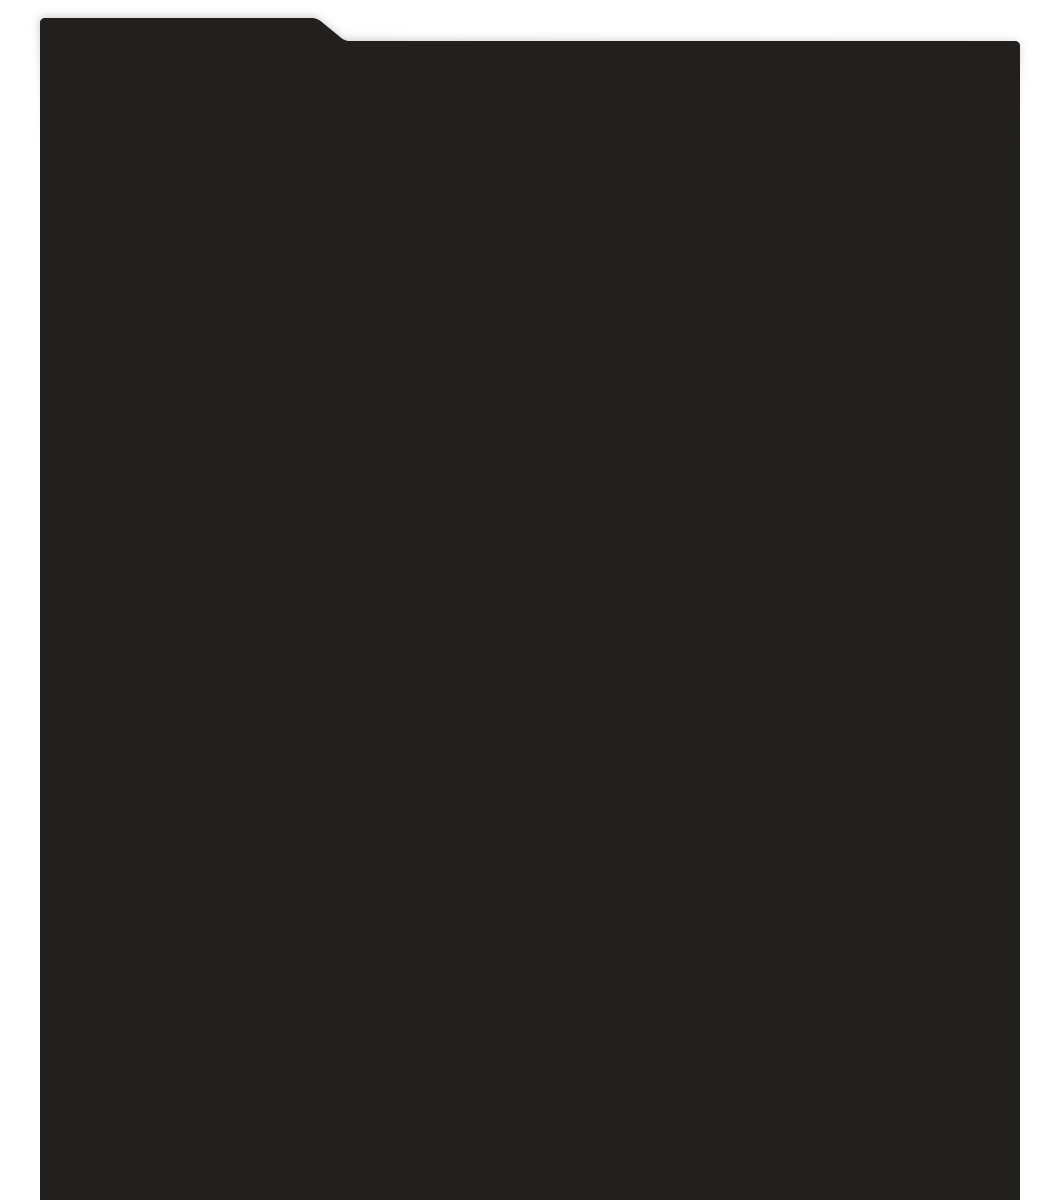
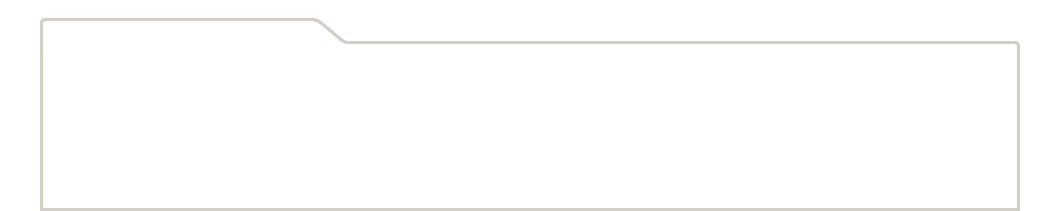
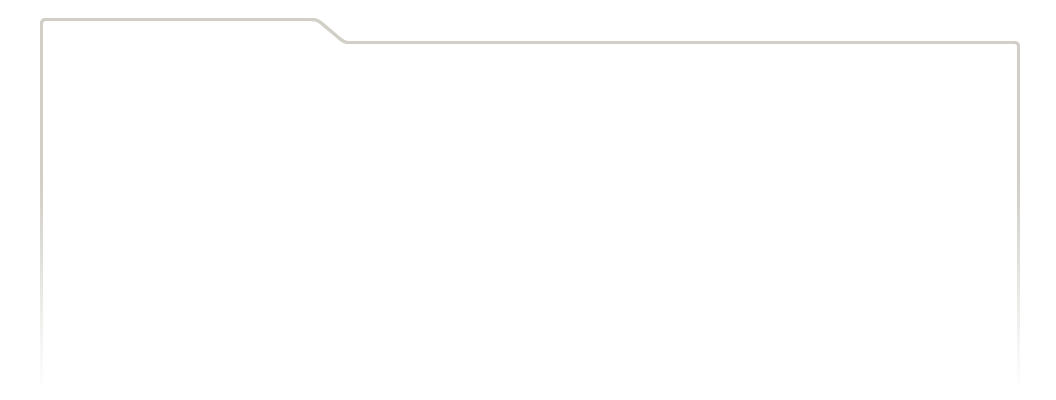
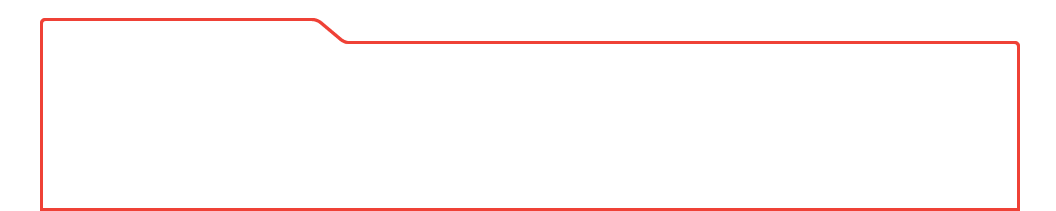
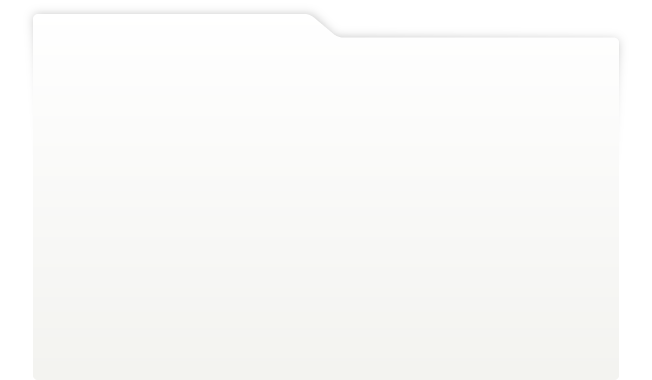
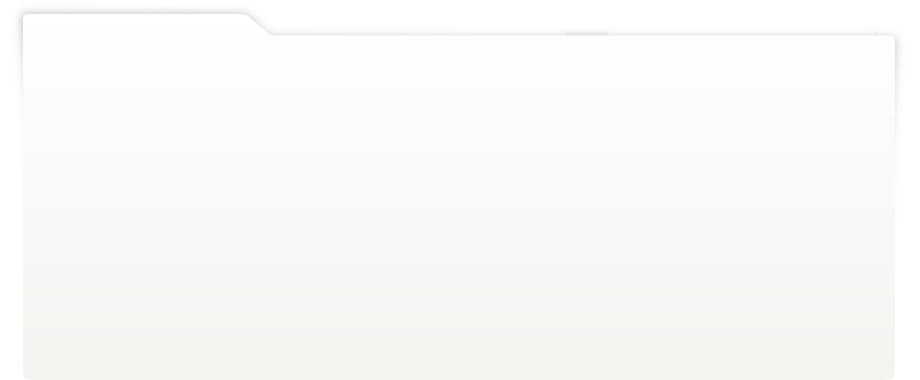
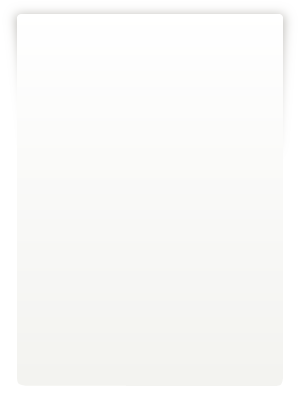
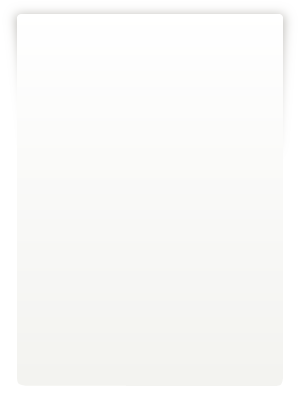
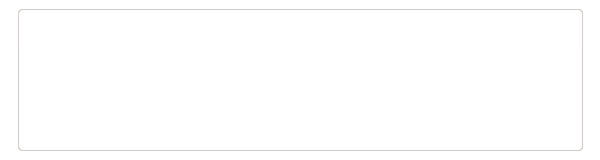
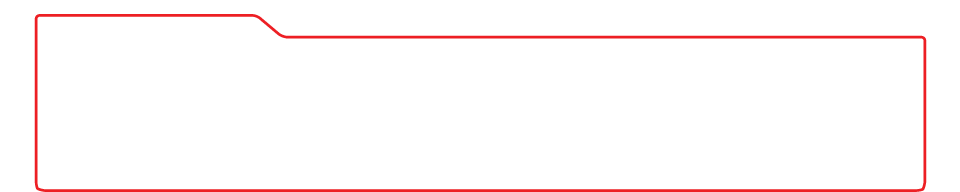
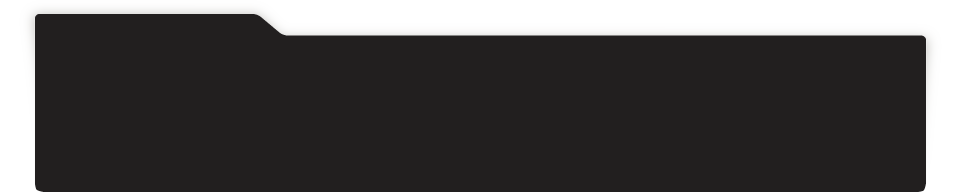
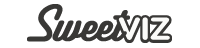
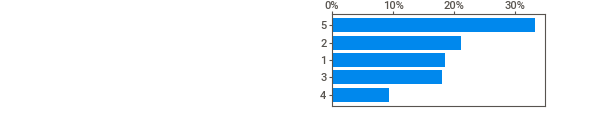
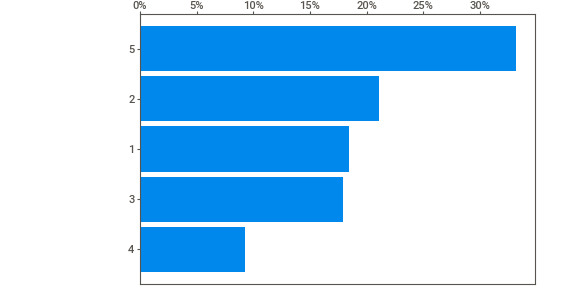
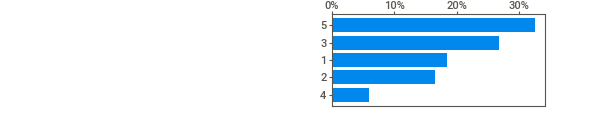
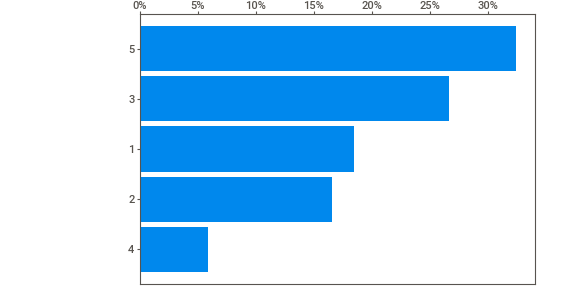
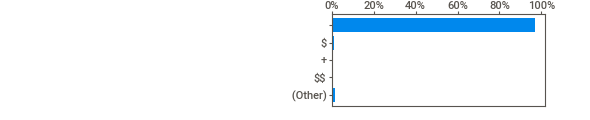
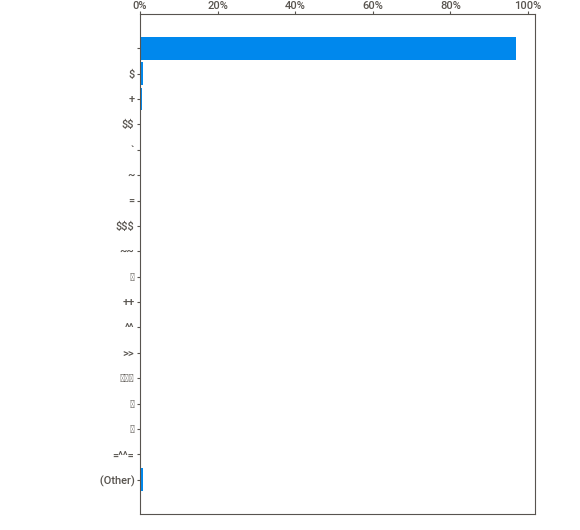
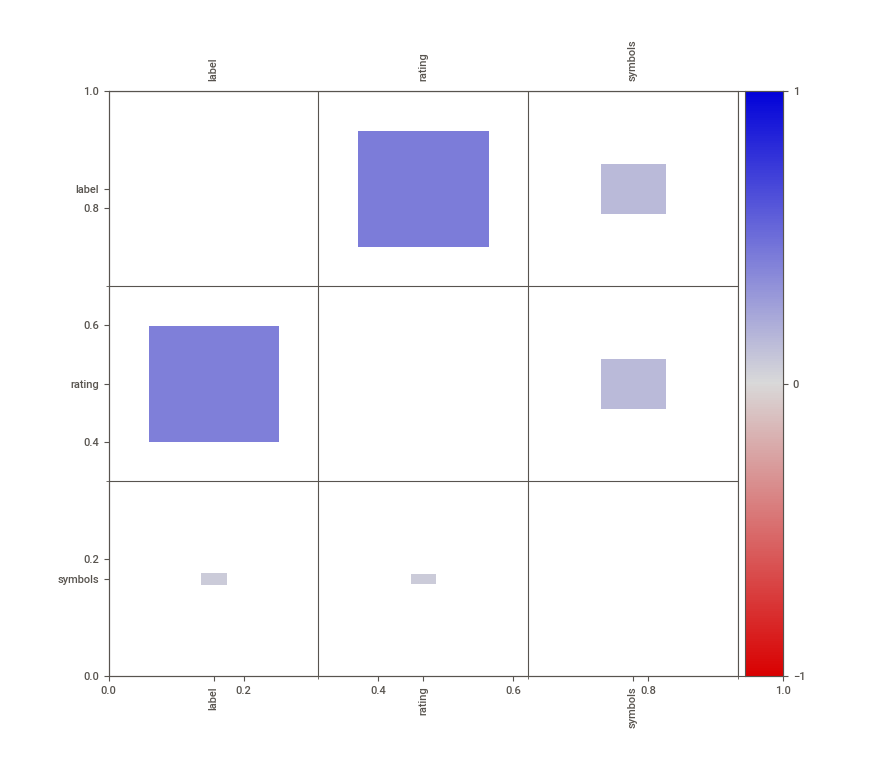
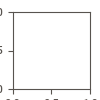

Report 'SWEETVIZ_REPORT.html' was saved to storage.


In [1]:
from src.core.stage import Stage
from src.utils.load_dataset_from_parquet import load_dataset_from_parquet
import sweetviz as sv
import pandas as pd

data = dict()
load_dataset_from_parquet(Stage("cleaning",[]), "data", data)

if 'dataset' in data:

    print(f"Loaded {data['dataset'].shape[0]} entries from dataset. Printing head and information about dataset shape.")
    print(data['dataset'].head(2))

    data['dataset'].describe()
    data['dataset'].info()
    print("Using sweetviz to generate a visual report on data...")
    report = sv.analyze(data['dataset'])
    report.show_notebook(filepath='SWEETVIZ_REPORT.html')


## Evaluation Visualizations

### Step 1: Generate confusion matrix from JSON output.

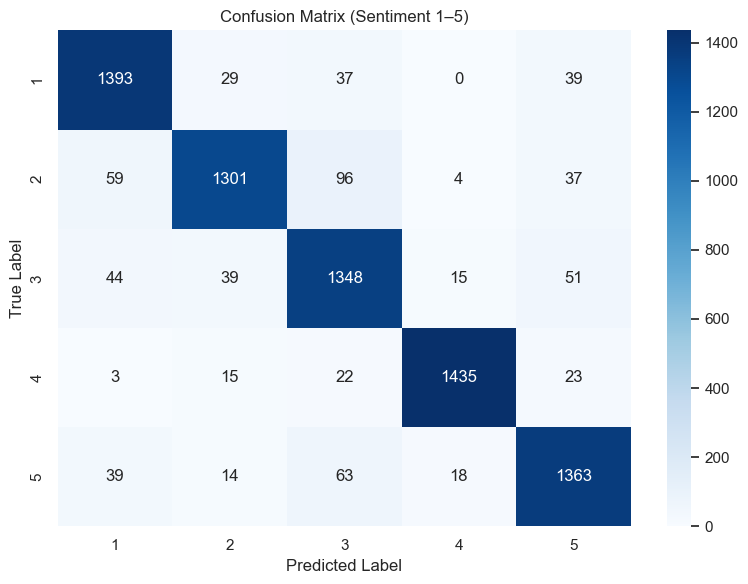

In [20]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import os

def plot_confusion_matrix_from_json(json_path,  export_path=None):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    y_true = [entry['true_label'] for entry in data]
    y_pred = [entry['predicted_label'] for entry in data]

    cm = confusion_matrix(y_true, y_pred, labels=[1, 2, 3, 4, 5])

    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[1, 2, 3, 4, 5],
                yticklabels=[1, 2, 3, 4, 5])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Sentiment 1–5)")
    plt.tight_layout()

    if export_path:
            acc_path = os.path.join(export_path, f"confusion.png")
            plt.savefig(acc_path, dpi=300)
    plt.show()
plot_confusion_matrix_from_json("./src/output/predictions_30k_rf.json", export_path="./")

### Step 2: Generate wordcloud of term frequency for high polarity data points.

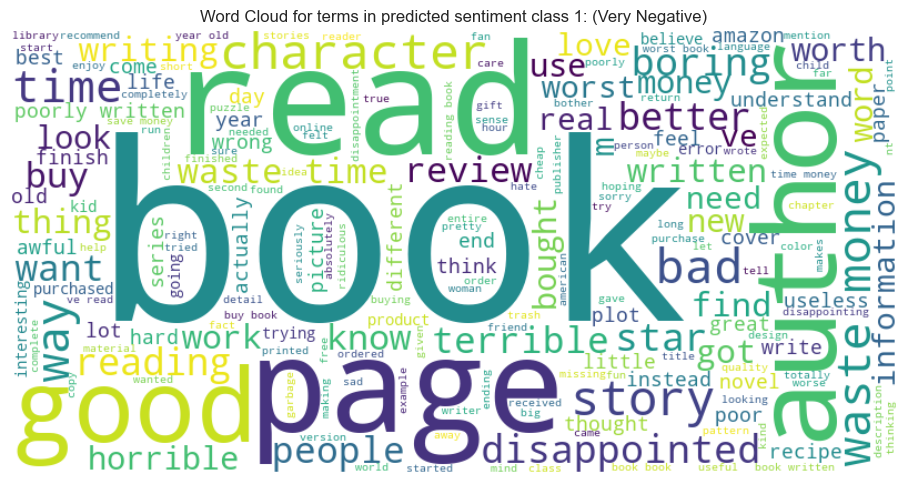

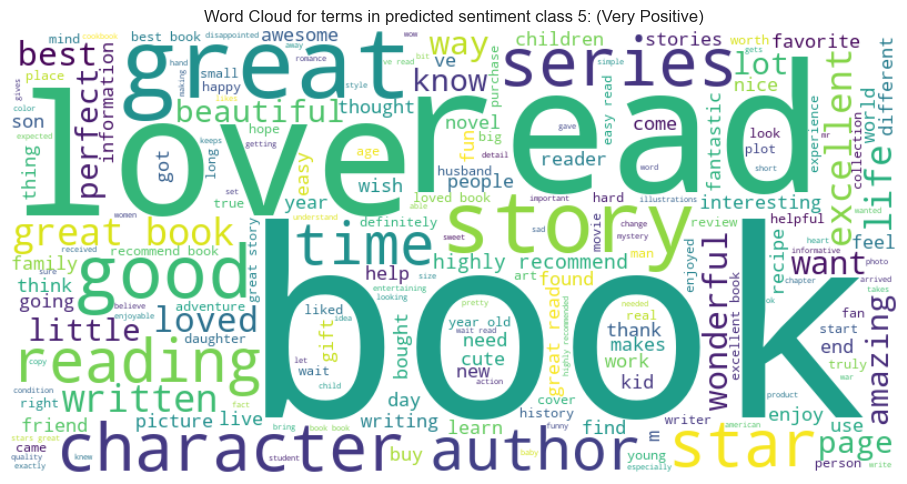

In [21]:
import json
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import os

nlp = spacy.load("en_core_web_sm")

def create_wordclouds_for_extremes(json_path,  export_path=None):
    # Load data
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    texts = defaultdict(list)
    for entry in data:
        label = entry["predicted_label"]
        if label == 1 or label == 5:
            texts[label].append(entry["text"])

    processed_texts = {}
    for label, samples in texts.items():
        tokens = []
        for text in samples:
            doc = nlp(text.lower())
            tokens.extend([token.text for token in doc if not token.is_stop and token.is_alpha])
        processed_texts[label] = " ".join(tokens)

    for label in [1, 5]:
        wc = WordCloud(width=800, height=400, background_color='white').generate(processed_texts[label])
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        sentiment = "Very Negative" if label == 1 else "Very Positive"
        plt.title(f"Word Cloud for terms in predicted sentiment class {label}: ({sentiment})")
        plt.tight_layout()

        if export_path:
            acc_path = os.path.join(export_path, f"wordcloud_{label}.png")
            plt.savefig(acc_path, dpi=300)
        plt.show()


create_wordclouds_for_extremes("./src/output/predictions_30k_rf.json", export_path="./")

### Step 3: Visualize differences in evaluation results

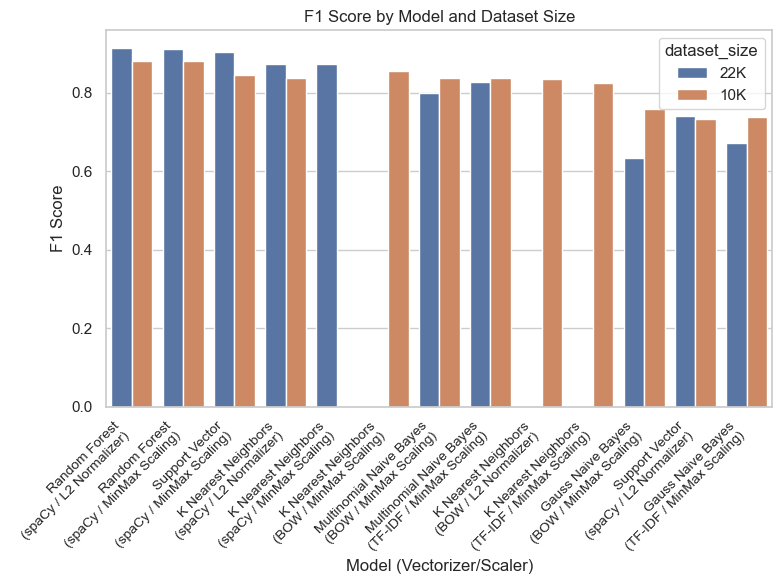

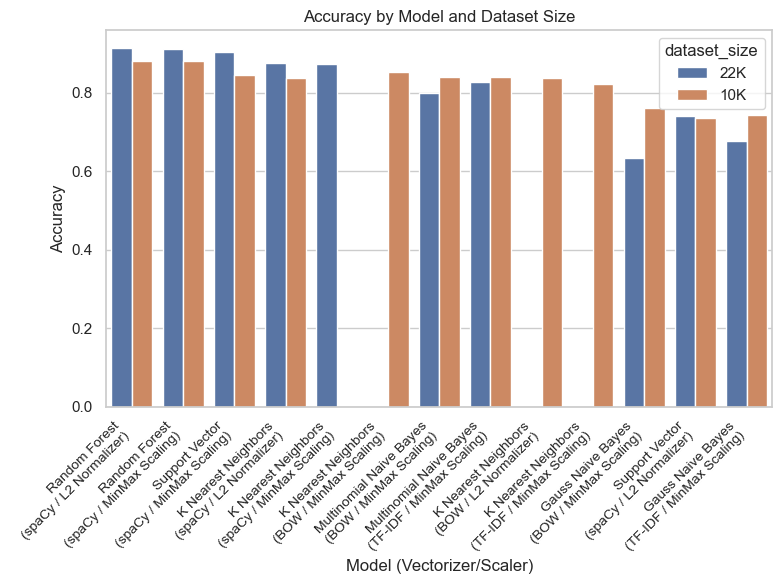

In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_model_comparison(csv_path, fig_width=14, fig_height=6,  export_path=None):
    df = pd.read_csv(csv_path)

    df.columns = [col.strip() for col in df.columns]
    df['dataset_size'] = df['dataset_size'].str.strip()
    df['model name'] = df['model name'].str.strip()
    df['vectorizer/scaler'] = df['vectorizer/scaler'].str.strip()

    def prettify_model_name(name):
        name = name.replace("_classification", "").replace("_", " ")
        return name.title()

    df['Model'] = df['model name'].apply(prettify_model_name)
    df['Label'] = df['Model'] + "\n(" + df['vectorizer/scaler'] + ")"

    df['f1 score'] = df['f1 score'].astype(float)
    df['accuracy'] = df['accuracy'].astype(float)

    # Sort by F1 score
    df = df.sort_values(by="f1 score", ascending=False)
    sns.set(style="whitegrid")

    # Plot F1 Score
    plt.figure(figsize=(fig_width, fig_height))
    sns.barplot(data=df, x="Label", y="f1 score", hue="dataset_size")
    plt.title("F1 Score by Model and Dataset Size")
    plt.ylabel("F1 Score")
    plt.xlabel("Model (Vectorizer/Scaler)")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.tight_layout()


    if export_path:
        f1_path = os.path.join(export_path, "f1_score_comparison.png")
        plt.savefig(f1_path, dpi=300)
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(fig_width, fig_height))
    sns.barplot(data=df, x="Label", y="accuracy", hue="dataset_size")
    plt.title("Accuracy by Model and Dataset Size")
    plt.ylabel("Accuracy")
    plt.xlabel("Model (Vectorizer/Scaler)")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.tight_layout()


    if export_path:
        acc_path = os.path.join(export_path, "accuracy_comparison.png")
        plt.savefig(acc_path, dpi=300)

    plt.show()

plot_model_comparison("./results_table.csv", 8, 6, export_path="./")

A better graph

C:\Users\Ferren\AppData\Local\Temp\ipykernel_16388\4053184331.py:31: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.barplot(


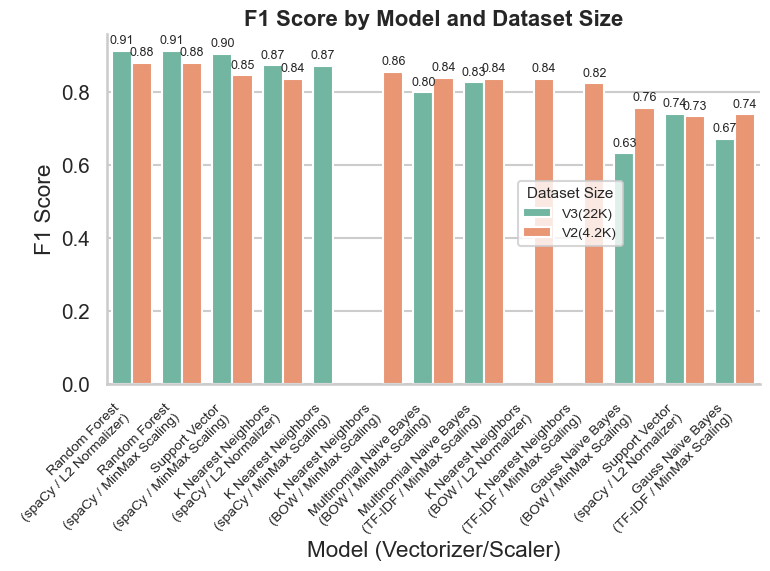

C:\Users\Ferren\AppData\Local\Temp\ipykernel_16388\4053184331.py:31: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.barplot(


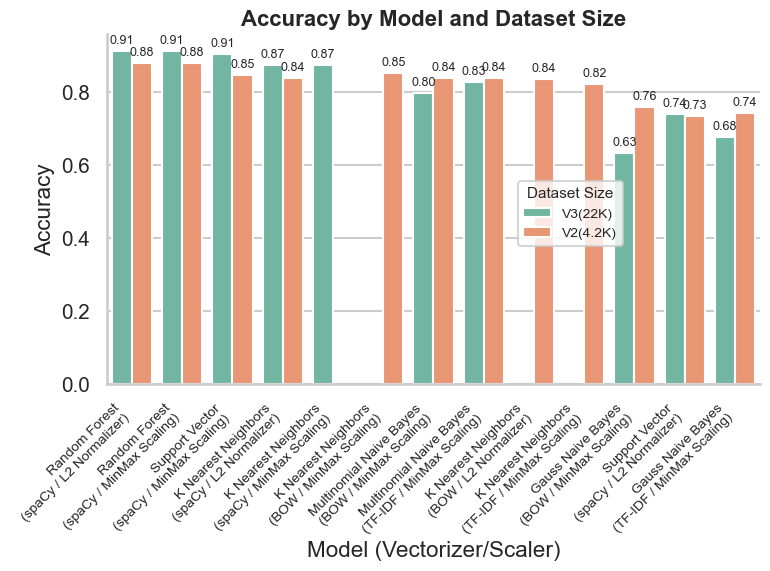

In [17]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_model_comparison(csv_path, fig_width=14, fig_height=6, export_path=None):
    df = pd.read_csv(csv_path)

    df.columns = [col.strip() for col in df.columns]
    df['dataset_size'] = df['dataset_size'].str.strip()
    df['model name'] = df['model name'].str.strip()
    df['vectorizer/scaler'] = df['vectorizer/scaler'].str.strip()

    def prettify_model_name(name):
        return name.replace("_classification", "").replace("_", " ").title()

    df['Model'] = df['model name'].apply(prettify_model_name)
    df['Label'] = df['Model'] + "\n(" + df['vectorizer/scaler'] + ")"

    df['f1 score'] = df['f1 score'].astype(float)
    df['accuracy'] = df['accuracy'].astype(float)

    df = df.sort_values(by="f1 score", ascending=False)

    # Set Seaborn style
    sns.set(style="whitegrid", context="talk", font_scale=0.9)
    palette = sns.color_palette("Set2")

    def draw_barplot(metric, title, ylabel, filename):
        plt.figure(figsize=(fig_width, fig_height))
        ax = sns.barplot(
            data=df,
            x="Label",
            y=metric,
            hue="dataset_size",
            palette=palette
        )

        # Add value annotations
        for container in ax.containers:
            ax.bar_label(container, fmt="%.2f", padding=3, fontsize=9)

        plt.title(title, fontsize=16, weight='bold')
        plt.ylabel(ylabel)
        plt.xlabel("Model (Vectorizer/Scaler)")
        plt.xticks(rotation=45, ha="right", fontsize=10)
        plt.legend(title="Dataset Size", title_fontsize=11, fontsize=10, bbox_to_anchor=(.8, .6))
        sns.despine()
        plt.tight_layout()

        if export_path:
            out_path = os.path.join(export_path, filename)
            plt.savefig(out_path, dpi=300)

        plt.show()

    draw_barplot("f1 score", "F1 Score by Model and Dataset Size", "F1 Score", "f1_score_comparison.png")
    draw_barplot("accuracy", "Accuracy by Model and Dataset Size", "Accuracy", "accuracy_comparison.png")
plot_model_comparison("./results_table.csv", 8, 6, export_path="./")